In [4]:
from dataset import FBDataset, collate_fn
from utils import *
import os, sys
import webbrowser
import argparse
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

In [3]:
checkpoint = torch.load("tw_model/model.pth.tar")

model = checkpoint['model']

for i,m in enumerate(model.modules()):
#     if isinstance(m, nn.Linear):
    print(i)
    print(m)
#         print(m.weight)

0
HierarchicalAttentionNetwork(
  (sent_attention): SentenceAttention(
    (word_attention): WordAttention(
      (embeddings): Embedding(50002, 100)
      (gru): GRU(100, 50, batch_first=True, dropout=0.1, bidirectional=True)
      (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (attention): Linear(in_features=100, out_features=10, bias=True)
      (context_vector): Linear(in_features=10, out_features=1, bias=False)
    )
    (gru): GRU(100, 50, batch_first=True, dropout=0.1, bidirectional=True)
    (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (sent_attention): Linear(in_features=100, out_features=10, bias=True)
    (sentence_context_vector): Linear(in_features=10, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=2, bias=True)
)
1
SentenceAttention(
  (word_attention): WordAttention(
    (embeddings): Embedding(500

In [3]:
from dataset import FBDataset, collate_fn

In [22]:
dataset = FBDataset("data/tw3/", "data/glove/glove.6B.100d.txt", split = 'test')

with open('data/tw3/train.pickle', 'rb') as handle:
    test_data = pickle.load(handle)


test_label = test_data['target']
test_doc = test_data['data']

In [6]:
input_doc = "i am drunk"

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orig_doc = [word_tokenize(sent) for sent in sent_tokenize(input_doc)]
doc, num_sents, num_words = dataset.transform(input_doc)
label = 0  # dummy label for transformation

doc, label, doc_length, sent_length = collate_fn([(doc, label, num_sents, num_words)])
score, word_att_weight, sentence_att_weight \
    = model(doc.to(device), doc_length.to(device), sent_length.to(device))


In [13]:
torch.softmax(score.detach(), dim=1).flatten().cpu()

tensor([0.0072, 0.9928])

# on test dataset

In [5]:
import pandas as pd
import os
import time
import pickle
from sklearn.model_selection import train_test_split

In [6]:
data_folder = "held_in_csv/"
labels_df = pd.read_csv(data_folder + "Y_held_in.csv")
labels_df.head()

,SMID,Diagnosis2,Score
0,101378,Negative,0
1,103694,Positive,2
2,106002,Negative,0
3,107667,Negative,0
4,107776,Negative,0


In [7]:
num = np.load('filtered0108/num.npy')
idx = num> 10

labels = labels_df.iloc[idx]
y = labels.Diagnosis2

In [20]:
SMIDs = labels.SMID.values
y = labels.Diagnosis2.values

SMID_train, SMID_test, y_train, y_test = train_test_split(
     SMIDs, y, test_size=0.2, random_state=42)

In [21]:
def divide_chunks(l, n):       
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [8]:
filtered_dir = "filtered0108/"

In [52]:
%%time

max_doc_len = 100

program_starts = time.time()
docs = []
targets = []
targets_prob = []
targets_mean = []
k = 0


for SMID in SMID_train:
    
    y = labels.loc[labels['SMID'] == SMID].Diagnosis2.values[0]
    if y == 'Negative':
        label = 0
    else: 
        label = 1
    targets.append(label)
    
    SMID = str(SMID)
    
    sentences_df = pd.read_csv(filtered_dir + SMID+ ".csv")
    

    
    msgs = sentences_df.Sentences
    
    msgs = msgs.sample(frac = 1) 
    
    msgs_trunks = divide_chunks(msgs, max_doc_len)
    probs = []
    
    for trunk in msgs_trunks:
        input_doc = ''  
        for msg in trunk:
            if str(msg) != 'nan' and str(msg) != 'NaN':
                msg = bytes(str(msg),'iso-8859-1').decode('utf-8')
                input_doc = input_doc + msg + '\n' 
     
        orig_doc = [word_tokenize(sent) for sent in sent_tokenize(input_doc)]
        doc, num_sents, num_words = dataset.transform(input_doc)
        label = 0  # dummy label for transformation

        if num_sents != -1:
            doc, label, doc_length, sent_length = collate_fn([(doc, label, num_sents, num_words)])
            score, word_att_weight, sentence_att_weight \
                = model(doc.to(device), doc_length.to(device), sent_length.to(device))

            prob = torch.softmax(score.detach(), dim=1).flatten().cpu()[1].item()
            probs.append(prob)
        
    targets_mean.append(mean(probs))
    targets_prob.append(probs)

    if k % 50 == 0:
        print("Saved "+ SMID)
        now = time.time()
        print("It has been {0:.2f} minutes since the loop started".format((now - program_starts)/60)) 
        
    k = k +1

Saved 900065
It has been 0.18 minutes since the loop started
Saved 347008
It has been 2.73 minutes since the loop started
Saved 800565
It has been 6.03 minutes since the loop started
Saved 295456
It has been 9.29 minutes since the loop started
Saved 891541
It has been 14.27 minutes since the loop started
Saved 656268
It has been 19.64 minutes since the loop started
Saved 916099
It has been 24.66 minutes since the loop started
Saved 750157
It has been 27.59 minutes since the loop started
Saved 849127
It has been 30.87 minutes since the loop started
Saved 988738
It has been 35.73 minutes since the loop started
Saved 367820
It has been 41.30 minutes since the loop started
CPU times: user 44min 33s, sys: 1.31 s, total: 44min 34s
Wall time: 44min 36s


In [53]:
data_dict = {
  "pred": targets_prob,
    "pred_mean": targets_mean,
  "target": targets
}

In [54]:
with open('major_train.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('major_test.pickle', 'rb') as handle:
    test = pickle.load(handle)

In [10]:
with open('major_train.pickle', 'rb') as handle:
    train = pickle.load(handle)

In [11]:
targets_mean = train['pred_mean']

In [12]:
targets = train['target']

In [13]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict,cross_val_score

In [17]:
X_test =  np.array(test['pred_mean']).reshape(-1, 1)
y_test = test['target']

In [14]:
X = np.array(targets_mean).reshape(-1, 1)

y = targets

lm = linear_model.LogisticRegression(class_weight='balanced')
predictions = cross_val_predict(lm, X, y, cv=5)
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       401
           1       0.45      0.68      0.54       121

    accuracy                           0.73       522
   macro avg       0.67      0.71      0.68       522
weighted avg       0.78      0.73      0.75       522



In [21]:
lm = linear_model.LogisticRegression(class_weight='balanced')
lm.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lm.predict(test)

In [31]:
X = np.array(test["pred_mean"]).reshape(-1, 1)

y = test["target"]

In [32]:
y_pred =  lm.predict(X)

In [33]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       101
           1       0.29      0.50      0.37        30

    accuracy                           0.61       131
   macro avg       0.55      0.57      0.54       131
weighted avg       0.69      0.61      0.64       131



# ROC AUC  for all data

In [55]:
X_all  = np.vstack((X,X_test))

In [56]:
y_all = np.hstack((y,y_test))

In [57]:
y_all.shape

(653,)

In [58]:
lm = linear_model.LogisticRegression(class_weight='balanced')
predictions = cross_val_predict(lm, X_all, y_all, cv=5)
print(classification_report(y_all, predictions))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       502
           1       0.41      0.65      0.51       151

    accuracy                           0.71       653
   macro avg       0.64      0.69      0.65       653
weighted avg       0.77      0.71      0.72       653



In [59]:
lm = linear_model.LogisticRegression(class_weight='balanced')
y_score = cross_val_predict(lm, X_all, y_all, cv=5, method='predict_proba')

In [39]:
predictions

array([[0.73609245, 0.26390755],
       [0.40617235, 0.59382765],
       [0.58612281, 0.41387719],
       ...,
       [0.42485097, 0.57514903],
       [0.76054695, 0.23945305],
       [0.59909302, 0.40090698]])

In [71]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle

In [61]:
y_true = y_all.reshape((-1,1))

In [62]:
enc = OneHotEncoder()
enc.fit(y_true)
y_true = enc.transform(y_true).toarray()

In [65]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(),y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [67]:
roc_auc

{0: 0.7538323527083718, 1: 0.7538323527083717, 'micro': 0.7611307453641925}

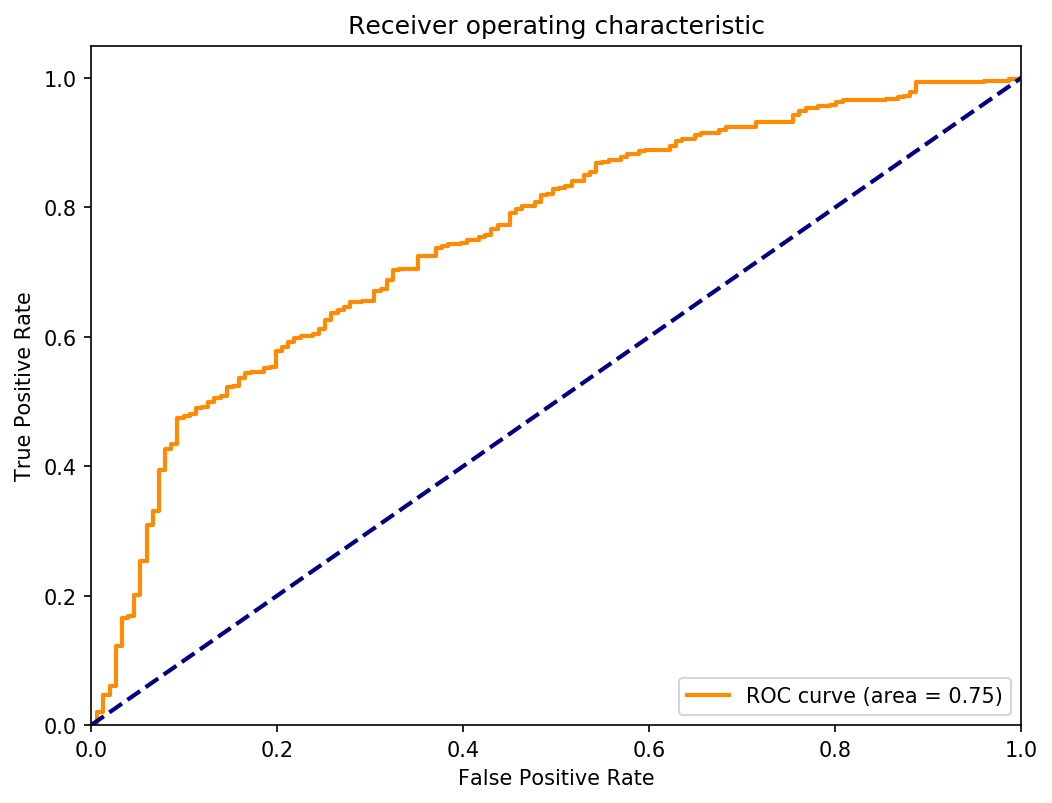

In [85]:
plt.figure(figsize=(8,6), dpi=150)
lw = 2
i = 0
plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_all, predictions)

0.6860570961188359

In [69]:
n_classes =  2

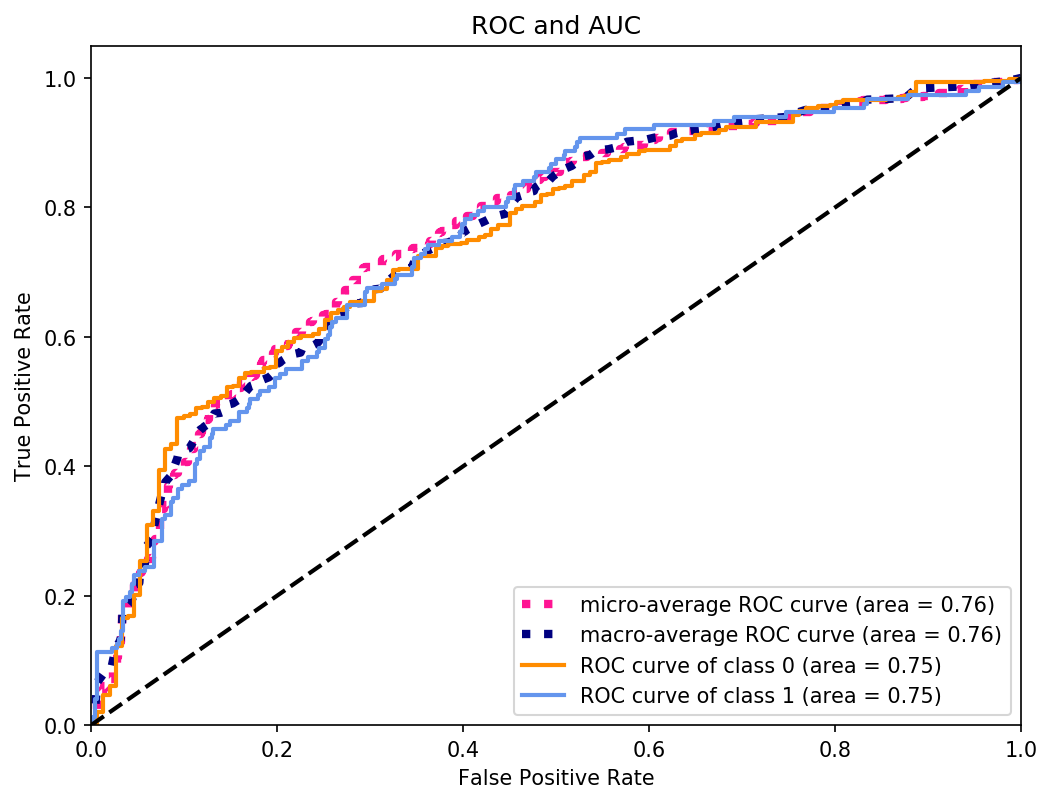

In [82]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6), dpi=150)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange'])
colors = ['darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="lower right")
plt.show()

In [87]:
X  =X_all
y = y_all

In [ ]:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [ ]:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [ ]:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

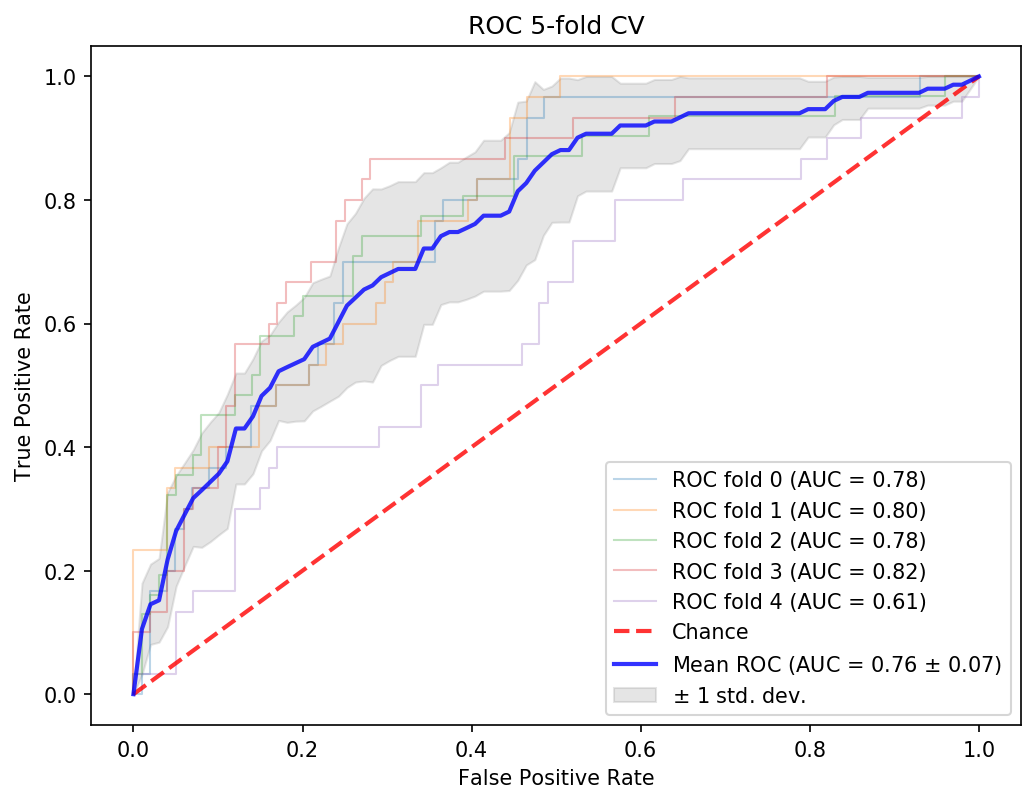

In [93]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold


n_samples, n_features = X.shape

random_state = np.random.RandomState(0)
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)
classifier =  linear_model.LogisticRegression(class_weight='balanced', random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# plt.figure(figsize=(8,6), dpi=150)
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC 5-fold CV")
ax.legend(loc="lower right")
plt.show()